In [1]:
# import libraries
import pandas as pd
import scipy.stats
import statsmodels.stats.multitest
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import labtools.statistics
import statsmodels.api as sm
import scipy.spatial
import itertools

# disable warnings, use w caution
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set wd
path = '/Users/KevinBu/Desktop/clemente_lab/Projects/twinspsd/'

In [3]:
# errors to rename
sub_dict =  {'RA_twin_550_0':'RA_550_0'}

##### Process Metadata #####

In [4]:
# load metadata
df_meta = pd.read_csv(path + 'inputs/twinspsd_metadata.txt', index_col='Sample_ID', sep='\t')
df_meta = df_meta.drop('Unnamed: 0', axis=1)

# create Diagnosis
df_meta['Diagnosis'] = df_meta['dx'].map(lambda x: 'PsO' if 'PsO' in x else ('PsA' if 'PsA' in x else 'HC'))

# create psd column for either pso or psa
df_meta['DxPsD'] = df_meta['dx'].map(lambda x: 'HC' if x == 'Healthy' else 'PsD')

# create twinpair identifier that links twins
df_meta['twinpair'] = df_meta['dob'].map(lambda x: x.replace('/',''))

# drop cols that are all NA
df_meta = df_meta.dropna(how='all',axis=1)

# replace all '-' with '_'
df_meta.index = df_meta.index.map(lambda x: x.replace('-','_'))

# replace via sub dict
df_meta = df_meta.rename(index=sub_dict)

# rename to # for simplicity
df_meta.index = df_meta.index.map(lambda x: x.split('_')[1])

df_meta.head()

,date_1,subject_id,visit,dx,early_ra,gender,ethnicity,race,arm,enrollment,age,dob,Smoker?,Site.1,Diagnosis,DxPsD,twinpair
Sample_ID,,,,,,,,,,,,,,,,,
542,2/14/20,542,0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,38,9/10/81,Never,NYU,PsO,PsD,91081
543,2/14/20,543,0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,38,9/10/81,Never,NYU,HC,HC,91081
544,1/24/20,544,0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,42,10/24/77,Never,NYU,PsO,PsD,102477
545,1/24/20,545,0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,42,10/24/77,Never,NYU,HC,HC,102477
546,2/10/20,546,0,Psoriatic arthritis (PsA),False,Female,Not Hispanic,Caucasian,twins.psa,Completed,47,6/4/72,FORMER SMOKER,NYU,PsA,PsD,6472


In [5]:
# Filter metadata
# two samples are repeated visit, keep only first timepoint?
# df_meta_filt = df_meta_filt[df_meta_filt['visit'] == 0]
# we have one twin coming in on a second visit whatever that means

# which twins are concordant? n=4
df = df_meta.groupby('twinpair')
df = df.dx.value_counts() == 2
df = df[df==True]
concordant_twins = list(df.index.get_level_values('twinpair'))

# 11169
# this is a PsO and PsA twin
concordant_twins.append('11169')
print(concordant_twins)

# drop concordant twins LATER
df_meta_filt = df_meta[~df_meta['twinpair'].isin(concordant_twins)]

df_meta_filt.head()

['101064', '102676', '3663', '6472', '11169']


,date_1,subject_id,visit,dx,early_ra,gender,ethnicity,race,arm,enrollment,age,dob,Smoker?,Site.1,Diagnosis,DxPsD,twinpair
Sample_ID,,,,,,,,,,,,,,,,,
542,2/14/20,542,0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,38,9/10/81,Never,NYU,PsO,PsD,91081
543,2/14/20,543,0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,38,9/10/81,Never,NYU,HC,HC,91081
544,1/24/20,544,0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,42,10/24/77,Never,NYU,PsO,PsD,102477
545,1/24/20,545,0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,42,10/24/77,Never,NYU,HC,HC,102477
550,8/6/21,550,0,Psoriatic arthritis (PsA),False,Female,Not Hispanic,Caucasian,twins.psa,Completed,60,10/30/60,Never,NYU,PsA,PsD,103060


In [6]:
# determine number of samples and subjects
df = df_meta_filt.copy()
df = df_meta.copy()

print('n_samples in metadata')
print(len(df.index.unique()))

print('n_subjects in metadata')
print(len(df.subject_id.unique()))

# determine Visit, DX, early_ra, gender, ethnicity, race, enrollment, smoker, site, site1. breakdown
# Site is useless, early_ra seems to also not give any info
# Ethnicity, Race also homogenous
keep = ['visit','dx','gender','enrollment','Smoker?','ethnicity']
for v in keep:
    print(df[v].value_counts())

n_samples in metadata
38
n_subjects in metadata
38
visit
0    37
2     1
Name: count, dtype: int64
dx
Psoriasis (PsO)              15
Healthy                      14
Psoriatic arthritis (PsA)     9
Name: count, dtype: int64
gender
Female    30
Male       8
Name: count, dtype: int64
enrollment
Enrolled     24
Completed    14
Name: count, dtype: int64
Smoker?
Never            29
FORMER SMOKER     6
Yes               3
Name: count, dtype: int64
ethnicity
Not Hispanic    38
Name: count, dtype: int64


In [43]:
# table 1
df = df_meta.copy()
# df = df.drop_duplicates(subset=['Study_ID'])

# select meta vars
meta_vars = ['Diagnosis','gender','age','Smoker?']

# binarize columns
df['Gender'] = df['gender'].apply(lambda x: 1 if x == 'Female' else 0)
df['Ever_Smoked'] = df['Smoker?'].apply(lambda x: 0 if x == 'Never' else 1)
df['Age'] = df['age'].astype(float)

# split into groups
df_HC = df[df['Diagnosis'] == 'HC']
df_PsO = df[df['Diagnosis'] == 'PsO']
df_PsA = df[df['Diagnosis'] == 'PsA']

var_name = ['n','Age (std)']
HC_stat = [str(len(df_HC)), str(np.round(df_HC['Age'].mean(),1)) + ' (' + str(np.round(np.std(df_HC['Age'],ddof=1),1)) + ')']
PsO_stat = [str(len(df_PsO)), str(np.round(df_PsO['Age'].mean(),1)) + ' (' + str(np.round(np.std(df_PsO['Age'],ddof=1),1)) + ')'] 
PsA_stat = [str(len(df_PsA)), str(np.round(df_PsA['Age'].mean(),1)) + ' (' + str(np.round(np.std(df_PsA['Age'],ddof=1),1)) + ')'] 

for x in ['Gender','Ever_Smoked']:
    var_name.append(x)
    HC_stat.append(str(df_HC[x].sum()) + ' (' + str(np.round(df_HC[x].mean()*100)) + '%)')
    PsO_stat.append(str(df_PsO[x].sum()) + ' (' + str(np.round(df_PsO[x].mean()*100)) + '%)')
    PsA_stat.append(str(df_PsA[x].sum()) + ' (' + str(np.round(df_PsA[x].mean()*100)) + '%)')

df_t1 = pd.DataFrame({'Variable': var_name, 'HC': HC_stat, 'PsO': PsO_stat, 'PsA': PsA_stat})
df_t1 = df_t1.set_index('Variable')
df_t1.to_csv(path + 'inputs/df_t1.tsv', sep='\t')

df_t1.head()


,HC,PsO,PsA
Variable,,,
n,14,15,9
Age (std),44.5 (13.1),45.2 (10.6),50.4 (11.3)
Gender,11 (79.0%),12 (80.0%),7 (78.0%)
Ever_Smoked,1 (7.0%),4 (27.0%),4 (44.0%)


##### jobs00: read retention #####

In [44]:
# import df
df_kd = pd.read_csv(path + 'outputs/jobs00/df_kd.tsv', sep='\t', index_col=0)

# sort by initial reads and then retained reads
df_kd = df_kd.sort_values(['initial_reads', 'retained'], ascending=[False, False])

# fix index
df_kd.index = df_kd.index.map(lambda x: x.split('_S')[0])
df_kd.index = df_kd.index.map(lambda x: x.replace('-','_'))
df_kd.index = df_kd.index.map(lambda x: x.split('_')[0])

# df_kd = df_kd.rename(index = sub_dict)

df_kd.head()

,initial_reads,trimmomatic_paired,trimmomatic_orphan,trf_paired,trf_single,human_paired,retained
519,59880811,12586219,1308233,169416,29519,6732,45679204
526,56510846,6933311,2388192,169055,78970,34319,46606337
542,50514032,4621113,2143671,158557,63298,18248,43258441
553,48378335,7037421,1153039,148370,18665,7338,39905075
550,47080232,7217082,1676894,139531,52294,22893,37771367


In [45]:
# name index
df = df_kd.copy()
df.index.name = 'SampleID'

# drop initial
df = df.drop('initial_reads',axis=1)

# flip df
df = df[df.columns[::-1]]

# name columns
s_to_name = {
    'trimmomatic_paired': 'Triommomatic (Paired)',
    'trimmomatic_orphan':'Triommomatic (Single)',
    'trf_paired': 'Tandom Repeats (Paired)',
    'trf_single': 'Tandom Repeats (Single)',
    'human_paired': 'Human Reads',
    'retained': 'Retained'
}
print(df.columns)
df = df.rename(columns=s_to_name)

# reset index
df = df.reset_index()

# stacked barplot
plt.figure(figsize=(10,6))
df.plot(x='SampleID', kind='bar', stacked='True', figsize=(8, 6), rot=0, ylabel='Read Count')
#ax.set_title('Read Retention', size=20, fontweight="bold")
#ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
sns.despine()

# hide x tick labels
plt.xticks([])

plt.savefig(path + 'outputs/jobs00/read_retention.pdf')
#ax.tick_params(axis='x', colors='red', which='both')
#ax.tick_params(axis='y', colors='purple', which='both')
plt.close()
# plt.show()

Index(['retained', 'human_paired', 'trf_single', 'trf_paired',
       'trimmomatic_orphan', 'trimmomatic_paired'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

In [46]:
# lowest 5 samples
df_low = df.sort_values(by=['Retained'], ascending=True)
df_low.head()

,SampleID,Retained,Human Reads,Tandom Repeats (Single),Tandom Repeats (Paired),Triommomatic (Single),Triommomatic (Paired)
39,544,20229660,56052,40035,76398,1043979,5604799
38,556,23019681,7285,30164,88731,1023180,4882244
37,531,23563473,25356,36482,87427,1158938,4793920
35,554,23920143,3472,41844,90432,1188179,5096914
33,530,24639355,11096,37295,95923,1080745,5482613


In [47]:
# mean, median, stdev
x = df_low[df_low['Retained'] > 8000].Retained
print(np.round(np.mean(x),0), np.round(np.median(x),0), np.round(np.std(x,ddof=1),0))
# df_low[

31035259.0 30045642.0 6316796.0


##### Rarefaction #####

In [ ]:
# Rarefied adiv over 1000 replicates
n_rep = 2
ts = []
ps = []
iters = []
df_abs = []
dfs = []
df_merges = []

def rarefy_table(df, seed):
    """Rarefies a taxa table to the smallest sequencing depth."""

    # Calculate the sequencing depth per sample (row sums)
    sample_depths = df.sum(axis=1)

    # Find the minimum sequencing depth
    min_depth = sample_depths.min()
    # min_depth = 1000
    print(min_depth)

    rarefied_dfs = [] # List to hold rarefied dataframes
    for index, row in df.iterrows(): # Loop through each sample
        print(index)
        np.random.seed(seed+1)
        # Create an array of read counts
        reads = np.repeat(row.index, row.values)

        # Subsample to the minimum depth
        if len(reads) > min_depth:
            subsampled_reads = np.random.choice(reads, int(min_depth), replace=False)
        else:
            subsampled_reads = reads # no need to subsample

        # Create a dataframe for the subsampled sample
        subsampled_df = pd.Series(subsampled_reads).value_counts().to_frame().T
        rarefied_dfs.append(subsampled_df)


    rarefied_df = pd.concat(rarefied_dfs) # Concatenate rarefied dfs into one df
    rarefied_df = rarefied_df.fillna(0) # Fill any missing columns with 0
    rarefied_df.index = df.index # Keep original indices

    return rarefied_df

for i in range(n_rep):
    # load table
    df_taxa = pd.read_csv(path + 'outputs/jobs01/metaphlan_taxa_table.tsv', sep='\t', index_col=0)

    # transpose
    df_taxa = df_taxa.T

    # remove the suffix for samples of taxa
    df_taxa.index = df_taxa.index.map(lambda x: x.split('_S')[0])
    
    # drop control
    # df_taxa = df_taxa.drop('RA_519_4_Before')

    # rename to # for simplicity
    df_taxa.index = df_taxa.index.map(lambda x: x.split('_')[0])

    # rarefy
    df_taxa = rarefy_table(df_taxa, i)

    # add to df abs
    df_ab = df_taxa.copy()

    # normalize
    df_taxa = df_taxa.div(df_taxa.sum(axis=1),axis=0)
    
    # remove the suffix for samples of taxa
    df_taxa.index = df_taxa.index.map(lambda x: x.split('_S')[0])
    
    # going to assume metadata is correct
    # df_taxa = df_taxa.rename(index = sub_dict)
    
    # entropy(pk, qk=None, base=None, axis=0, *, nan_policy='propagate', keepdims=False)[source]
    df_se = pd.DataFrame({'Alpha_Diversity': scipy.stats.entropy(df_taxa, axis=1)}, index=df_taxa.index)
    
    # merge with meta
    df_merge = pd.concat([df_meta, df_se],axis=1)
    
    # print result of ttest
    df_PsO = df_merge[df_merge['Diagnosis'] == 'PsO']
    df_PsA = df_merge[df_merge['Diagnosis'] == 'PsA']
    df_HC = df_merge[df_merge['Diagnosis'] == 'HC']
    t,p = scipy.stats.ttest_ind(df_PsO['Alpha_Diversity'],df_HC['Alpha_Diversity'])
    print(t,p)
    iters.append(i)
    ts.append(t)
    ps.append(p)
    df_abs.append(df_ab)
    dfs.append(df_taxa)
    df_merges.append(df_merge)

# save results of rarefaction
for i,df in enumerate(dfs):
    df.to_csv(path + 'inputs/df_taxa_rare' + '31769150' + '_rep' + str(i) + '.tsv', sep='\t')

for i,df in enumerate(df_merges):
    df.to_csv(path + 'inputs/df_merge_alpha_rare' + '31769150' + '_rep' + str(i) + '.tsv', sep='\t')



PearsonRResult(statistic=-0.11175250417643778, pvalue=0.49238020267506644)


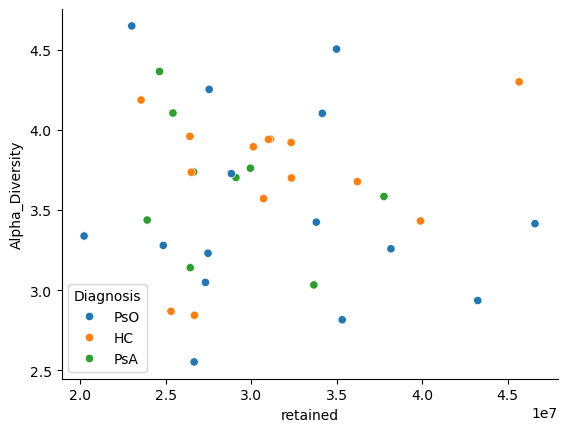

In [55]:
# check corr between adiv and coverage
df_taxa = pd.read_csv(path + 'inputs/df_taxa_rare' + '31769150' + '_rep' + str(0) + '.tsv', sep='\t', index_col=0)
df_taxa.index.name = 'Sample_ID'
df_taxa.index = df_taxa.index.map(lambda x: str(x))

# going to assume that in the taxa table, we need to rename 
df_taxa = df_taxa.rename(index = sub_dict)

# entropy(pk, qk=None, base=None, axis=0, *, nan_policy='propagate', keepdims=False)[source]
df_se = pd.DataFrame({'Alpha_Diversity': scipy.stats.entropy(df_taxa, axis=1)}, index=df_taxa.index)

# merge with meta
df_merge_alpha = pd.concat([df_meta, df_se],axis=1)

df_merge = pd.concat([df_merge_alpha, df_kd],axis=1)
df_merge = df_merge.dropna(subset='Alpha_Diversity')
# df_merge = df_merge[df_merge['retained'] < 4e7]
df_merge.dropna(subset='visit').to_csv(path + 'inputs/df_merge_alpha_kd.tsv', sep='\t')

print(scipy.stats.pearsonr(df_merge['Alpha_Diversity'],df_merge['retained']))
sns.scatterplot(x='retained',y='Alpha_Diversity',hue='Diagnosis',data=df_merge)
sns.despine()

##### Alpha Div #####

In [50]:
# correlation between shannon entropy and rarefied shannon entropy
df_taxa = pd.read_csv(path + 'outputs/jobs01/metaphlan_taxa_table.tsv', sep='\t', index_col=0)

# transpose and normalize
df_taxa = df_taxa.T
df_taxa = df_taxa.div(df_taxa.sum(axis=1),axis=0)

# remove the suffix for samples of taxa
df_taxa.index = df_taxa.index.map(lambda x: str(x.split('_S')[0]))

# going to assume metadata is correct
# ['RA_538_TW_PSO_0' 'RA_539_TW_NML_0']

# grab rarefied table
df_taxa = pd.read_csv(path + 'inputs/df_taxa_rare' + '31769150' + '_rep' + str(0) + '.tsv', sep='\t', index_col=0)
df_taxa.index.name = 'Sample_ID'
df_taxa.index = df_taxa.index.map(lambda x: str(x))

# going to assume that in the taxa table, we need to rename 
df_taxa = df_taxa.rename(index = sub_dict)

# entropy(pk, qk=None, base=None, axis=0, *, nan_policy='propagate', keepdims=False)[source]
df_se = pd.DataFrame({'Alpha_Diversity': scipy.stats.entropy(df_taxa, axis=1)}, index=df_taxa.index)

# merge with meta
df_merge_alpha = pd.concat([df_meta, df_se],axis=1)

# drop control
# df_merge_alpha = df_merge_alpha.drop('RA_519_4_Before')

# determine lack of intersectoin
seq_idx = df_se.index.values
meta_idx = df_meta.index.values
print(set(seq_idx).difference(set(meta_idx)))
# 'RA_538_TW_NML_0', 'RA_553_TW_NML_', 'RA_539_TW_PSO_0', 'RA_526_TW_PSO_0', 'RA_519_4_Before', 
# 'RA_527_TW_NML_V2', 'RA_551_TW_NML_0', 'RA_552_TW_0', 'RA_twin_550_0'

print(set(meta_idx).difference(set(seq_idx)))
# 'RA_539_TW_NML_0', 'RA_538_TW_PSO_0'

# export
# df_merge_alpha.drop('RA_519_4_Before').to_csv(path + 'inputs/df_merge_alpha.tsv', sep='\t')
df_merge_alpha.to_csv(path + 'inputs/df_merge_alpha.tsv', sep='\t')

# filtered
df_merge_alpha_filt = pd.concat([df_meta_filt, df_se],axis=1)

# drop those without pairings
df_merge_alpha_filt = df_merge_alpha_filt.dropna()

df_merge_alpha_filt.to_csv(path + 'inputs/df_merge_alpha_filt.tsv', sep='\t')
df_merge_alpha.head()

{'563', '562'}
set()


,date_1,subject_id,visit,dx,early_ra,gender,ethnicity,race,arm,enrollment,age,dob,Smoker?,Site.1,Diagnosis,DxPsD,twinpair,Alpha_Diversity
Sample_ID,,,,,,,,,,,,,,,,,,
542,2/14/20,542.0,0.0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,38.0,9/10/81,Never,NYU,PsO,PsD,91081,2.935515
543,2/14/20,543.0,0.0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,38.0,9/10/81,Never,NYU,HC,HC,91081,2.843736
544,1/24/20,544.0,0.0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,42.0,10/24/77,Never,NYU,PsO,PsD,102477,3.337801
545,1/24/20,545.0,0.0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,42.0,10/24/77,Never,NYU,HC,HC,102477,3.676907
546,2/10/20,546.0,0.0,Psoriatic arthritis (PsA),False,Female,Not Hispanic,Caucasian,twins.psa,Completed,47.0,6/4/72,FORMER SMOKER,NYU,PsA,PsD,6472,3.702243


HCvPsD
14
24
-0.899185331846457 0.37452932333489763
HCvPsD
132.0 0.28269771221950357
HCvPsO
14
15
-1.0526881121725364 0.3018142599400187
HCvPsO
75.0 0.1979251021111571
HCvPsA
14
9
-0.33330179333005333 0.7422113608729435
HCvPsA
57.0 0.7289914546163012
PsAvPsO
9
15
0.635824749820729 0.5314499036974325
PsAvPsO
84.0 0.3400554635028641


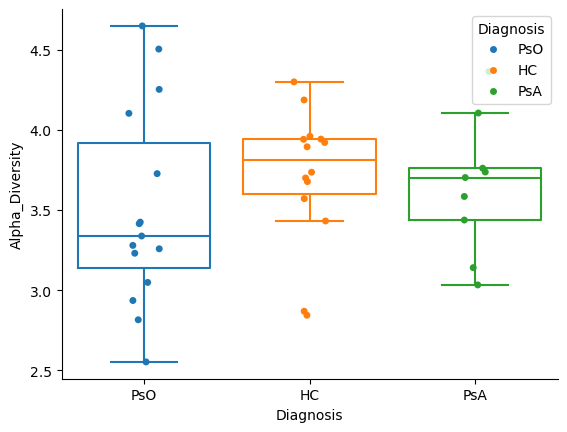

In [56]:
# adiv plots
# unpaired
df = df_merge_alpha.copy()

df_PsO = df[df['Diagnosis'] == 'PsO']
df_PsA = df[df['Diagnosis'] == 'PsA']
df_PsD = df[df['Diagnosis'].isin(['PsA','PsO'])]
df_HC = df[df['Diagnosis'] == 'HC']

t,p = scipy.stats.ttest_ind(df_PsD['Alpha_Diversity'].values,df_HC['Alpha_Diversity'].values)
print('HCvPsD')
print(len(df_HC['Alpha_Diversity'].values))
print(len(df_PsD['Alpha_Diversity'].values))
print(t,p)
t,p = scipy.stats.mannwhitneyu(df_PsD['Alpha_Diversity'].values,df_HC['Alpha_Diversity'].values)
print('HCvPsD')
print(t,p)
t,p = scipy.stats.ttest_ind(df_PsO['Alpha_Diversity'].values,df_HC['Alpha_Diversity'].values)
print('HCvPsO')
print(len(df_HC['Alpha_Diversity'].values))
print(len(df_PsO['Alpha_Diversity'].values))
print(t,p)
t,p = scipy.stats.mannwhitneyu(df_PsO['Alpha_Diversity'].values,df_HC['Alpha_Diversity'].values)
print('HCvPsO')
print(t,p)
t,p = scipy.stats.ttest_ind(df_PsA['Alpha_Diversity'].values,df_HC['Alpha_Diversity'].values)
print('HCvPsA')
print(len(df_HC['Alpha_Diversity'].values))
print(len(df_PsA['Alpha_Diversity'].values))
print(t,p)
t,p = scipy.stats.mannwhitneyu(df_PsA['Alpha_Diversity'].values,df_HC['Alpha_Diversity'].values)
print('HCvPsA')
print(t,p)
t,p = scipy.stats.ttest_ind(df_PsA['Alpha_Diversity'].values,df_PsO['Alpha_Diversity'].values)
print('PsAvPsO')
print(len(df_PsA['Alpha_Diversity'].values))
print(len(df_PsO['Alpha_Diversity'].values))
print(t,p)
t,p = scipy.stats.mannwhitneyu(df_PsA['Alpha_Diversity'].values,df_PsO['Alpha_Diversity'].values)
print('PsAvPsO')
print(t,p)


sns.boxplot(data=df, x='Diagnosis', y='Alpha_Diversity',hue='Diagnosis',fill=None,showfliers=False,legend=False)
sns.stripplot(data=df, x='Diagnosis', y='Alpha_Diversity',hue='Diagnosis')
sns.despine()


HCvPsD
14
14
-0.36669704053777846 0.7197443893544431
45.0 0.6697998046875
HCvPsO
10
10
-0.16696850971718752 0.8710860445721852
26.0 0.921875
HCvPsA
4
4
-0.6707147294735496 0.5504204923923892
3.0 0.625


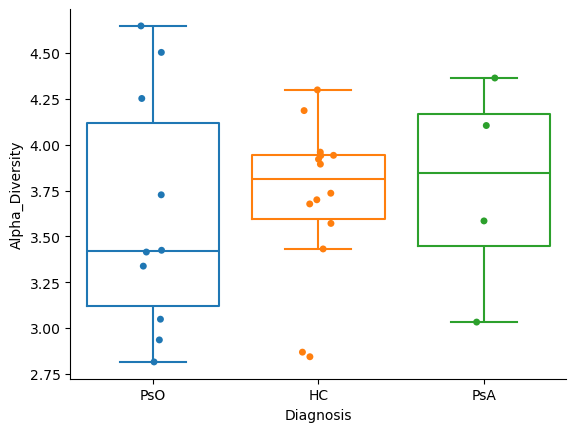

In [57]:
# adiv plots
# paired
df = df_merge_alpha_filt.copy()
comp_to_keep = {}

df_PsO = df[df['Diagnosis'] == 'PsO']
df_PsA = df[df['Diagnosis'] == 'PsA']
df_PsD = df[df['Diagnosis'].isin(['PsA','PsO'])]
df_HC = df[df['Diagnosis'] == 'HC']
#t,p = scipy.stats.ttest_ind(df_PsO['Alpha_Diversity'],df_HC['Alpha_Diversity'])
#print(t,p)
keep_PsD = list(set(df_PsD['twinpair'].values).intersection(set(df_HC['twinpair'].values)))
df_keep_HCvPsD = df[df['twinpair'].isin(keep_PsD)]
keep_HC = df_keep_HCvPsD[df_keep_HCvPsD['Diagnosis']=='HC'].index
keep_PsD = df_keep_HCvPsD[df_keep_HCvPsD['Diagnosis'].isin(['PsA','PsO'])].index
comp_to_keep['HCvPsD'] = (keep_HC, keep_PsD)

print('HCvPsD')
print(len(keep_HC))
print(len(keep_PsD))
t,p = scipy.stats.ttest_1samp(df_PsD.loc[keep_PsD,'Alpha_Diversity'].values-df_HC.loc[keep_HC,'Alpha_Diversity'].values,popmean=0)
print(t,p)
t,p = scipy.stats.wilcoxon(df_PsD.loc[keep_PsD,'Alpha_Diversity'].values-df_HC.loc[keep_HC,'Alpha_Diversity'].values)
print(t,p)

keep_PsO = list(set(df_PsO['twinpair'].values).intersection(set(df_HC['twinpair'].values)))
df_keep_HCvPsO = df[df['twinpair'].isin(keep_PsO)]
keep_HC = df_keep_HCvPsO[df_keep_HCvPsO['Diagnosis']=='HC'].index
keep_PsO = df_keep_HCvPsO[df_keep_HCvPsO['Diagnosis'] == 'PsO'].index
comp_to_keep['HCvPsO'] = (keep_HC, keep_PsO)

print('HCvPsO')
print(len(keep_HC))
print(len(keep_PsO))
t,p = scipy.stats.ttest_1samp(df_PsO.loc[keep_PsO,'Alpha_Diversity'].values-df_HC.loc[keep_HC,'Alpha_Diversity'].values,popmean=0)
print(t,p)
t,p = scipy.stats.wilcoxon(df_PsO.loc[keep_PsO,'Alpha_Diversity'].values-df_HC.loc[keep_HC,'Alpha_Diversity'].values)
print(t,p)

keep_PsA = list(set(df_PsA['twinpair'].values).intersection(set(df_HC['twinpair'].values)))
df_keep_HCvPsA = df[df['twinpair'].isin(keep_PsA)]
keep_HC = df_keep_HCvPsA[df_keep_HCvPsA['Diagnosis']=='HC'].index
keep_PsA = df_keep_HCvPsA[df_keep_HCvPsA['Diagnosis'] == 'PsA'].index
comp_to_keep['HCvPsA'] = (keep_HC, keep_PsA)

print('HCvPsA')
print(len(keep_HC))
print(len(keep_PsA))
t,p = scipy.stats.ttest_1samp(df_PsA.loc[keep_PsA,'Alpha_Diversity'].values-df_HC.loc[keep_HC,'Alpha_Diversity'].values,popmean=0)
print(t,p)
t,p = scipy.stats.wilcoxon(df_PsA.loc[keep_PsA,'Alpha_Diversity'].values-df_HC.loc[keep_HC,'Alpha_Diversity'].values)
print(t,p)


#t,p = scipy.stats.ttest_ind(df_PsA['Alpha_Diversity'],df_HC['Alpha_Diversity'])
#print(t,p)
#t,p = scipy.stats.ttest_ind(df_PsD['Alpha_Diversity'],df_HC['Alpha_Diversity'])
#print(t,p)

sns.boxplot(data=df, x='Diagnosis', y='Alpha_Diversity',hue='Diagnosis',fill=None,showfliers=False,legend=False)
sns.stripplot(data=df, x='Diagnosis', y='Alpha_Diversity',hue='Diagnosis')
sns.despine()


##### Intra alpha #####

##### Beta Div #####

In [58]:
# beta plots
import skbio
import labtools.statistics

# compute dm

dm_full = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(df_taxa.values, metric='braycurtis'))
df_dist = pd.DataFrame(dm_full, index=df_taxa.index, columns=df_taxa.index)

for x in [['HC','PsO'],['HC','PsA'],['HC','PsD'],['PsO','PsA']]:
    print(x)
    
    # get samples
    if 'PsD' in x:
        df_sub = df_merge.copy()
    else:
        df_sub = df_merge[df_merge['Diagnosis'].isin(x)]
    
    keep = df_sub.index
    
    # subset distance matrix
    dm = df_dist.loc[keep,keep]

    # get dx
    if 'PsD' in x:
        dx = df_sub['DxPsD']
    else:
        dx = df_sub['Diagnosis']
    
    # do permanova
    pF, p = labtools.statistics.permanova_oneway(dm, levels=dx)
    print(p)


    # do paired samples only
    if 'HC' in x:
        print('paired')
        x1, x2 = x
        df_sub = df_merge.loc[list(comp_to_keep[x1 + 'v' + x2][0]) + list(comp_to_keep[x1 + 'v' + x2][1]),:]
    
        keep = df_sub.index
        # subset distance matrix
        dm = df_dist.loc[keep,keep]
    
        # get dx
        dx = df_sub['Diagnosis']
        
        # do permanova
        pF, p = labtools.statistics.permanova_oneway(dm, levels=dx)
        print(p)
    


results = skbio.stats.ordination.pcoa(dm_full, method='eigh' , number_of_dimensions=0 , inplace=False )  
df_pcoa = results.samples
df_pcoa.index = df_taxa.index
# results is class OrdinationResults
# eigvals
# samples
# features
# biplot_scores = Correlation coefficients of the samples with respect to the features.
# sample_constraints
# proportion_explained
pe1, pe2 = results.proportion_explained[0:2]
print('pe')
print(pe1,pe2)

# this looks like the qiime one
# df_pcoa.head()
df_pc = df_pcoa.copy()
df_pc.head()

['HC', 'PsO']
0.221
paired
0.568
['HC', 'PsA']
0.262
paired
0.102
['HC', 'PsD']
0.246
paired
0.416
['PsO', 'PsA']
0.941
pe
0.20200180141705046 0.09405785332659111


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40
Sample_ID,,,,,,,,,,,,,,,,,,,,,
518,-0.191368,0.095995,-0.174975,-0.000154,0.026639,-0.125301,-0.006796,0.174550,0.127799,0.041165,...,-0.027367,0.025727,-0.006253,-0.018552,-0.019118,0.014184,-0.009191,-0.010241,-0.0,0.0
519,-0.207890,0.023032,-0.215929,-0.006953,0.036094,-0.074313,0.033380,0.010153,0.023658,0.049518,...,-0.008362,0.027586,-0.046106,0.011103,-0.020769,-0.016793,-0.010140,-0.005996,-0.0,0.0
520,-0.290344,-0.070949,0.002191,0.025039,0.030656,-0.005761,0.054708,-0.009102,-0.096660,-0.083490,...,-0.008641,-0.050198,-0.030034,-0.038676,-0.074137,0.013567,-0.012807,-0.003520,-0.0,0.0
521,0.034081,-0.031886,-0.079938,-0.161088,0.071626,0.085797,0.017509,-0.026133,-0.071505,-0.053807,...,-0.027287,0.033410,0.024283,-0.010331,0.045984,-0.013431,-0.028429,0.010209,-0.0,0.0
524,0.370730,0.029469,-0.020687,-0.109303,0.120693,0.094398,0.077563,0.093159,0.237372,0.008138,...,-0.062277,0.028937,0.012744,-0.008911,0.035940,-0.027159,0.009581,0.001936,-0.0,0.0


Text(0, 0.5, 'PC2 (9.4%)')

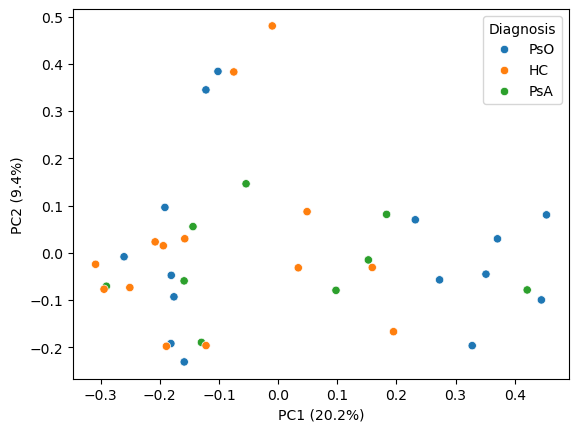

In [59]:
# beta over time
# merge the timepoint specific samples with the df_pc
df_merge_beta = pd.concat([df_meta, df_pc],axis=1)# .dropna(subset=['PC1','Age'])
df_merge_beta.to_csv(path + 'outputs/jobs02/bray_curtis_pcoa.tsv', sep='\t')

# create sns-less figure
# plt.figure(figsize=(4,3))

plt.figure()
sns.scatterplot(x='PC1',y='PC2',hue='Diagnosis',data=df_merge_beta)
plt.xlabel('PC1 (' + str(np.round(pe1 * 100, 1)) + '%)')
plt.ylabel('PC2 (' + str(np.round(pe2 * 100, 1)) + '%)')
                
# plt.savefig(path + 'outputs/jobs02/beta_' + 'Age' + '_PC1_PC2.pdf')
# plt.close()

##### Conc vs Disc #####

In [ ]:
# are concordant twins more similar to each other than discordant twins?
# test in alpha space first
df_alpha = df_merge_alpha.copy()
df_alpha = df_alpha.dropna(subset='visit')

# create a new column that designates concordant vs discordant
df_alpha['concordance'] = df_alpha['twinpair'].apply(lambda x: 'conc' if x in concordant_twins else 'disc')

# for concordant twins, get the vector of alpha div differences; may need to abs value
df_conc = df_alpha[df_alpha['concordance'] == 'conc']
df_disc = df_alpha[df_alpha['concordance'] == 'disc']

# compute alpha deltas
conc_alpha_delta = df_conc.drop_duplicates(subset='twinpair',keep='first')['Alpha_Diversity'].values - df_conc.drop_duplicates(subset='twinpair',keep='last')['Alpha_Diversity'].values
print(np.mean(conc_alpha_delta),np.std(conc_alpha_delta,ddof=1))

disc_alpha_delta = df_disc.drop_duplicates(subset='twinpair',keep='first')['Alpha_Diversity'].values - df_disc.drop_duplicates(subset='twinpair',keep='last')['Alpha_Diversity'].values
print(np.mean(disc_alpha_delta),np.std(disc_alpha_delta,ddof=1))

r,p = scipy.stats.mannwhitneyu(x=conc_alpha_delta,y=disc_alpha_delta)
print(r,p)
r,p = scipy.stats.ttest_ind(a=conc_alpha_delta,b=disc_alpha_delta)
print(r,p)

df = pd.DataFrame({'del_alpha': np.concatenate([conc_alpha_delta,disc_alpha_delta]),
                   'concordance': ['conc'] * len(conc_alpha_delta) + ['disc'] * len(disc_alpha_delta)})

sns.boxplot(data=df, x='concordance',y='del_alpha',hue='concordance')
sns.stripplot(data=df, x='concordance',y='del_alpha',color='black')
sns.despine()

In [ ]:
# are concordant twins more similar to each other than discordant twins?
# beta diversity test
df_alpha = df_merge_alpha.copy()
df_alpha = df_alpha.dropna(subset='visit')

# create a new column that designates concordant vs discordant
df_alpha['concordance'] = df_alpha['twinpair'].apply(lambda x: 'conc' if x in concordant_twins else 'disc')

# for concordant twins, get the vector of alpha div differences; may need to abs value
df_conc = df_alpha[df_alpha['concordance'] == 'conc']
df_disc = df_alpha[df_alpha['concordance'] == 'disc']

# grab beta deltas
conc_beta_delta = []
for x in df_conc.twinpair.unique():
    df_sub = df_conc[df_conc['twinpair'] == x]
    id1, id2 = df_sub.index.values
    dist = df_dist.loc[id1,id2]
    conc_beta_delta.append(dist)

disc_beta_delta = []
for x in df_disc.twinpair.unique():
    df_sub = df_disc[df_disc['twinpair'] == x]
    id1, id2 = df_sub.index.values
    dist = df_dist.loc[id1,id2]
    disc_beta_delta.append(dist)

# compute beta deltas
print(np.mean(disc_beta_delta),np.std(disc_beta_delta,ddof=1))
print(np.mean(conc_beta_delta),np.std(conc_beta_delta,ddof=1))

r,p = scipy.stats.mannwhitneyu(x=conc_beta_delta,y=disc_beta_delta)
print(r,p)
r,p = scipy.stats.ttest_ind(a=conc_beta_delta,b=disc_beta_delta)
print(r,p)

df = pd.DataFrame({'del_beta': np.concatenate([conc_beta_delta,disc_beta_delta]),
                   'concordance': ['conc'] * len(conc_beta_delta) + ['disc'] * len(disc_beta_delta)})

sns.boxplot(data=df, x='concordance',y='del_beta',hue='concordance')
sns.stripplot(data=df, x='concordance',y='del_beta',color='black')
sns.despine()

##### DA #####

In [62]:
# get taxa table non normalized
df_taxa = pd.read_csv(path + 'outputs/jobs01/metaphlan_taxa_table.tsv', sep='\t', index_col=0)

# transpose 
df_taxa = df_taxa.T

# remove the suffix for samples of taxa
df_taxa.index = df_taxa.index.map(lambda x: str(x.split('_')[0]))

# TSS
df_taxa_tss = df_taxa.div(df_taxa.sum(axis=1),axis=0)

# CLR
df_taxa_rclr = labtools.statistics.rclr(df_taxa)

# merge tables
# df_merge_rclr
df_merge = pd.concat([df_meta,df_taxa_tss],axis=1)

df_merge = df_merge.dropna(subset='visit')
df_merge.head()                     

,date_1,subject_id,visit,dx,early_ra,gender,ethnicity,race,arm,enrollment,...,k Bacteria|p Synergistetes|c Synergistia|o Synergistales|f Synergistaceae|g Cloacibacillus|s Cloacibacillus porcorum,k Bacteria|p Tenericutes|c CFGB1787|o OFGB1787|f FGB1787|g GGB4745|s GGB4745 SGB6571,k Bacteria|p Tenericutes|c CFGB1787|o OFGB1787|f FGB1787|g GGB4750|s GGB4750 SGB6579,k Bacteria|p Tenericutes|c CFGB1789|o OFGB1789|f FGB1789|g GGB4754|s GGB4754 SGB6584,k Bacteria|p Tenericutes|c CFGB1800|o OFGB1800|f FGB1800|g GGB13818|s GGB13818 SGB6606,k Bacteria|p Verrucomicrobia|c Opitutae|o Puniceicoccales|f Puniceicoccaceae|g GGB6123|s GGB6123 SGB8767,k Bacteria|p Verrucomicrobia|c Opitutae|o Puniceicoccales|f Puniceicoccaceae|g GGB6125|s GGB6125 SGB8771,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia muciniphila,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia sp BIOML A66,k Bacteria|p Verrucomicrobia|c Verrucomicrobiae|o Verrucomicrobiales|f Akkermansiaceae|g Akkermansia|s Akkermansia sp KLE1798
542,2/14/20,542.0,0.0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002610,0.0,0.0
543,2/14/20,543.0,0.0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.296454,0.0,0.0
544,1/24/20,544.0,0.0,Psoriasis (PsO),False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
545,1/24/20,545.0,0.0,Healthy,False,Female,Not Hispanic,Caucasian,twins.psa,Enrolled,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
546,2/10/20,546.0,0.0,Psoriatic arthritis (PsA),False,Female,Not Hispanic,Caucasian,twins.psa,Completed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039767,0.0,0.0


In [63]:
# for HC-PsO twins let's find differential taxa via pairwise wilcoxon
df = df_merge.copy()

# filter on concordant pairs only
df = df[~df['twinpair'].isin(concordant_twins)]

# filter on PsO and HC only
df = df[df['Diagnosis'].isin(['HC','PsO'])]

# keep paired samples
df = df[df.duplicated(subset='twinpair', keep=False)]

# keep only relevant columns and rename 
keep = ['Diagnosis','twinpair'] + list(df_taxa)
df = df[keep]

# 12 pairs remaining
# filter on taxa
# Function to modify column names (e.g., add "_new" suffix)
def split_taxa(col_name):
    if 'k  ' in col_name:
        return col_name.split('|s  ')[-1]
    else:
        return col_name
        
# Apply the function to column names
df = df.rename(columns=split_taxa)

# save to csv
df.to_csv(path + 'outputs/jobs03/0_taxa/taxa.tsv', sep='\t')
df.head()

,Diagnosis,twinpair,GGB260 SGB362,Candidatus Methanomassiliicoccus intestinalis,Methanobrevibacter smithii,Methanosphaera stadtmanae,Actinobaculum sp oral taxon 183,Actinomyces SGB17132,Actinomyces bouchesdurhonensis,Actinomyces dentalis,...,Cloacibacillus porcorum,GGB4745 SGB6571,GGB4750 SGB6579,GGB4754 SGB6584,GGB13818 SGB6606,GGB6123 SGB8767,GGB6125 SGB8771,Akkermansia muciniphila,Akkermansia sp BIOML A66,Akkermansia sp KLE1798
542,PsO,91081,0.000000,0.0,0.000000,0.000000,0.000000,0.000009,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.002610,0.0,0.0
543,HC,91081,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.296454,0.0,0.0
544,PsO,102477,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
545,HC,102477,0.000000,0.0,0.000000,0.000000,0.000015,0.000000,0.000099,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
556,PsO,71683,0.000079,0.0,0.009708,0.001987,0.000008,0.000000,0.000218,0.000044,...,0.0,0.000825,0.0,0.0,0.0,0.000012,0.000057,0.010725,0.0,0.0


In [68]:
# parse stats
df = pd.read_csv(path + 'outputs/jobs03/0_taxa/0_taxa_stats_clean.csv')#, sep='\t')
df = df.set_index('feature')

# filter on p
# df = df[df['fdr_adjusted'] < 0.05]
df = df[df['wilcoxon'] < 0.05]
df

,Unnamed: 0,wilcoxon,ttest,wilcox stat,ttest stat,fdr_adjusted
feature,,,,,,
Clostridium SGB4750,699,0.029974,0.068005,34,2.073248,1.0
Clostridium sp AM49 4BH,721,0.044011,0.037159,5,-2.443366,1.0
Clostridium sp Marseille P3244,727,0.036032,0.224293,0,-1.304929,1.0
Enterocloster hominis,877,0.032969,0.035427,4,-2.472460,1.0
Clostridium scindens,951,0.034611,0.123694,27,1.698206,1.0
Eubacterium rectale,959,0.037109,0.053090,7,-2.225444,1.0
Lachnospira eligens,972,0.017817,0.026269,43,2.654802,1.0
Roseburia sp AF02 12,1001,0.036032,0.133687,0,-1.648330,1.0
Simiaoa sunii,1005,0.034611,0.068460,1,-2.069137,1.0


##### Scratch #####